In [1]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
import os

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# File to Load (Remember to Change These)
path1 = os.path.join("data", "mouse_drug_data.csv")
path2 = os.path.join("data", "clinicaltrial_data.csv")

# Read the Mouse and Drug Data and the Clinical Trial Data
mouse_df = pd.read_csv(path1)
clinical_df = pd.read_csv(path2)

# Combine the data into a single dataset
df = pd.merge(mouse_df, clinical_df, on = "Mouse ID", how = 'outer')

# Display the data table for preview
df

,Mouse ID,Drug,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,f234,Stelasyn,0,45.000000,0
1,f234,Stelasyn,5,47.313491,0
2,f234,Stelasyn,10,47.904324,0
3,f234,Stelasyn,15,48.735197,1
4,f234,Stelasyn,20,51.112713,2
...,...,...,...,...,...
1901,j235,Placebo,0,45.000000,0
1902,j235,Placebo,5,46.588820,0
1903,j235,Placebo,10,48.018788,1
1904,j235,Placebo,15,51.161138,1


## Tumor Response to Treatment

In [2]:
# Store the Mean Tumor Volume Data Grouped by Drug and Timepoint 

col_list = ['Drug', 'Timepoint']
tumor = 'Tumor Volume (mm3)'

def group_mean(df, group_cols, out_col):
    return pd.DataFrame(df.groupby(group_cols).mean()[out_col])


def group_sem(df, group_cols, out_col):
    return pd.DataFrame(df.groupby(group_cols).sem()[out_col])

def group_count(df, group_cols, out_col):
    return pd.DataFrame(df.groupby(group_cols).count()[out_col])

tum_vol = group_mean(df, col_list, tumor)
tum_sem = group_sem(df, col_list, tumor)

# Minor Data Munging to Re-Format the Data Frames
def tranpose_multindex(df, col):
    df = df.reset_index().pivot('Timepoint', 'Drug', col)
    return df

T_tum_vol = tranpose_multindex(tum_vol, tumor)
T_tum_sem = tranpose_multindex(tum_sem, tumor)
##how can i generalize this function??

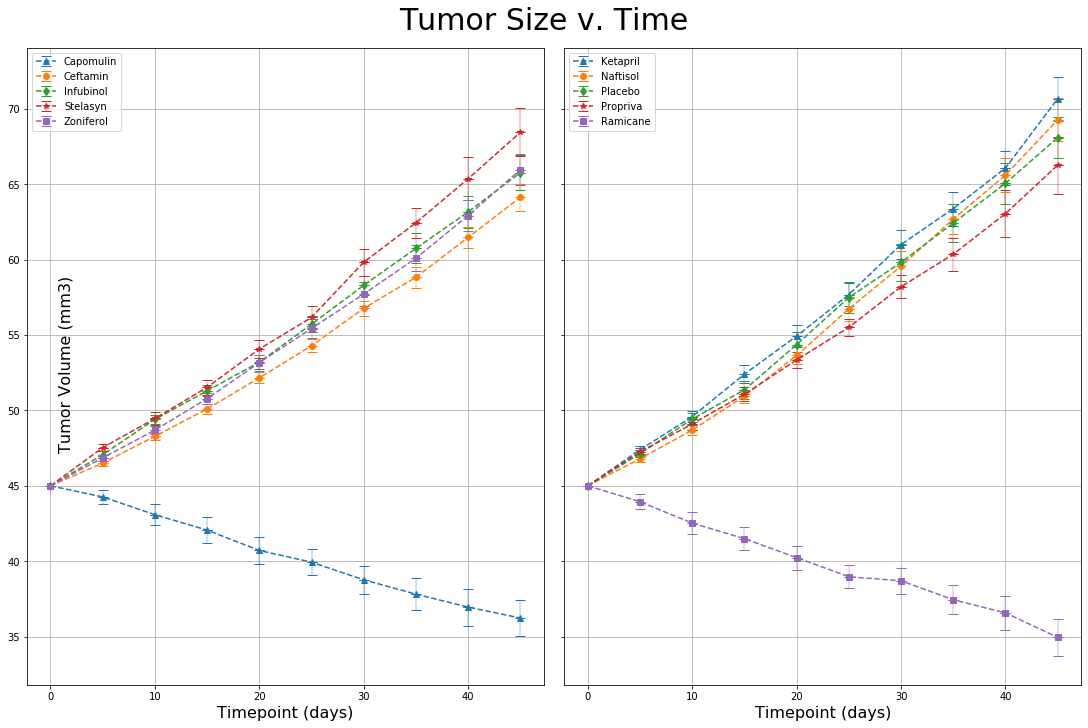

In [58]:
# Generate the Plot (with Error Bars)

formatz = ['--^', '--o', '--d', '--*', '--s']
xaxis = df.Timepoint.unique()

fig, axs = plt.subplots(1, 2, figsize = (15,10), sharex= 'all', sharey='all', constrained_layout=True)
fig.suptitle('Tumor Size v. Time', fontsize = 30)
axs[0].set_xlabel('Timepoint (days)', fontsize = 16)
axs[1].set_xlabel('Timepoint (days)', fontsize = 16)
fig.text(0.05, .5, 'Tumor Volume (mm3)', va='center', rotation='vertical', fontsize = 16)
axs[0].grid()
axs[1].grid()



for col, coll, f in zip(T_tum_vol.iloc[:, [0,1,2,8,9]], T_tum_vol.iloc[:, [3,4,5,6,7]], formatz):
    #storing the 'ErrorBarContainer' in mark, cap, bar works because maybe the container references 3 tuples to store the plot data, we
    #can then use them to specify what we may to make opaque
    markers, caps, bars = axs[0].errorbar(xaxis, T_tum_vol[col], yerr = T_tum_sem[col], uplims=True,\
                    lolims=True, label = col,  fmt=f, capsize = 5)
    mark, cap, bar = axs[1].errorbar(xaxis, T_tum_vol[coll], yerr = T_tum_sem[coll], uplims=True,\
                    lolims=True, label = coll,  fmt =f, capsize = 5)
    
    #set opacity of error bars by referencing the tuple created 
    for bs, ba in zip(bars, bar):
        bs.set_alpha(.3)
        ba.set_alpha(.3)
    
    for cs, ca in zip(caps, cap):
        ca.set_marker((2, 0, 90))
        cs.set_marker((2, 0, 90))

axs[0].legend()
axs[1].legend()

fig.savefig('TumorSize_v_Time.png')

plt.show()

## Metastatic Response to Treatment

In [46]:
# Store the Mean Met. Site Data Grouped by Drug and Timepoint 
# Convert to DataFrame# Preview DataFrame
meta = 'Metastatic Sites'

met_site_mean = group_mean(df, col_list, meta)
met_site_sem = group_sem(df, col_list, meta)

# Minor Data Munging to Re-Format the Data Frames
T_met_site_mean = tranpose_multindex(met_site_mean,meta)
T_met_site_sem = tranpose_multindex(met_site_sem, meta)

<Figure size 864x1080 with 0 Axes>

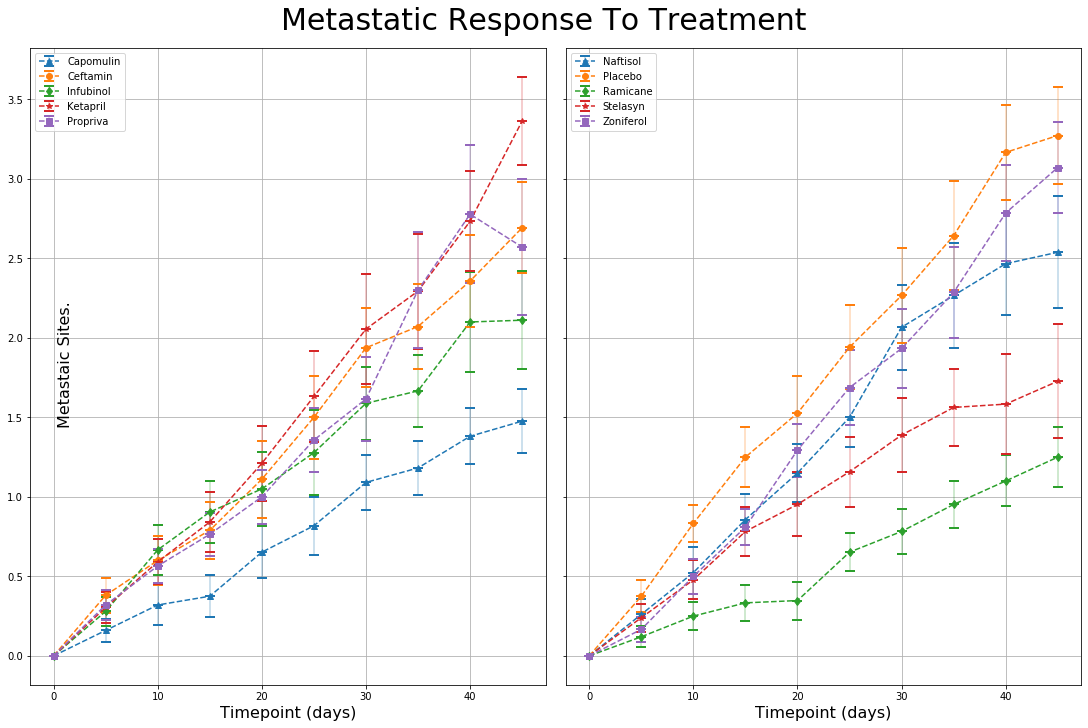

In [163]:
# Generate the Plot (with Error Bars)
plt.figure(figsize=(12,15))
fig, axs = plt.subplots(1, 2, figsize = (15,10), sharex= 'all', sharey='all', constrained_layout=True)
fig.suptitle('Metastatic Response To Treatment', fontsize = 30)
axs[0].set_xlabel('Timepoint (days)', fontsize = 16)
axs[1].set_xlabel('Timepoint (days)', fontsize = 16)
fig.text(0.05, .5, 'Metastaic Sites.', va='center', rotation='vertical', fontsize = 16)
axs[0].grid()
axs[1].grid()


for col1, col2 , f in zip(T_met_site_mean.iloc[:, [0,1,2,3,6]], T_met_site_mean.iloc[:,[4,5,7,8,9]], formatz):
    markers, caps, bars = axs[0].errorbar(xaxis, T_met_site_mean[col1], yerr = T_met_site_sem[col1], uplims=True,\
                    lolims=True, label = col1,  fmt=f, capsize = 5, capthick=2)
    mark, cap, bar = axs[1].errorbar(xaxis, T_met_site_mean[col2], yerr = T_met_site_sem[col2], uplims=True,\
                    lolims=True, label = col2,  fmt=f, capsize = 5, capthick=2)
    for bs, ba in zip(bars, bar):
        bs.set_alpha(.3)
        ba.set_alpha(.3)
    
    for cs, ca in zip(caps, cap):
        ca.set_marker((2, 0, 90))
        cs.set_marker((2, 0, 90))
axs[0].legend()
axs[1].legend()
    
plt.savefig('Met Response')

plt.show()
# Save the Figure

# Show the Figure


![Metastatic Spread During Treatment](../Images/spread.png)

## Survival Rates

In [62]:
# Store the Count of Mice Grouped by Drug and Timepoint (W can pass any metric)
mic = 'Mouse ID'
m = group_count(df, col_list, mic)
T_m = tranpose_multindex(m, mic)

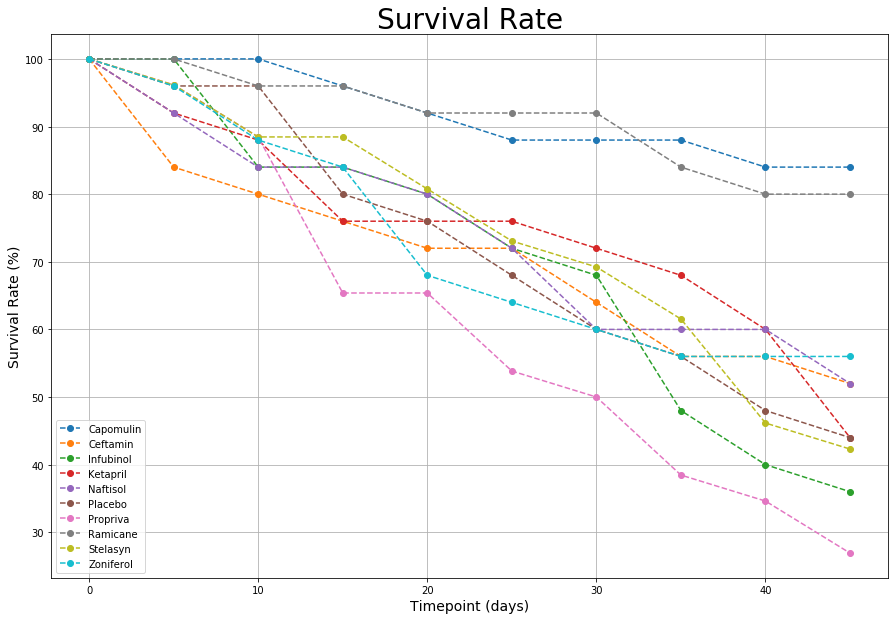

In [76]:
# Generate the Plot (Accounting for percentages)

plt.figure(figsize=(15,10))
plt.title('Survival Rate', fontsize=28)
plt.grid()


plt.xlabel('Timepoint (days)', fontsize=14)
plt.ylabel('Survival Rate (%)', fontsize=14)
#xaxis = df.Timepoint.unique()
for col in T_m:
    plt.errorbar(xaxis, ((T_m[col]/T_m.loc[0, col]) * 100), uplims=True, lolims=True, label = col, fmt='--o')
plt.legend()

plt.savefig('Survival Rate.png')

plt.show()

![Metastatic Spread During Treatment](../Images/survival.png)

## Summary Bar Graph

In [169]:
# Calculate the percent changes for each drug

In [165]:
drug_list = []
change_list = []
for col in T_tum_vol:
    drug_list.append(col)
    change_list.append((T_tum_vol.loc[45, col] - T_tum_vol.loc[0, col]) / T_tum_vol.loc[0, col])

change_per = [ "{:.2%}".format(e) for e in change_list]

change_df = pd.DataFrame({"Percent": [e * 100 for e in change_list],
                          "Percent_Change" : change_per}, index = drug_list)
sorted_df = change_df.sort_values('Percent') #for grpahs

# Display the data to confirm
change_df



,Percent,Percent_Change
Ramicane,-22.320900,-22.32%
Capomulin,-19.475303,-19.48%
Ceftamin,42.516492,42.52%
Infubinol,46.123472,46.12%
Zoniferol,46.579751,46.58%
Propriva,47.241175,47.24%
Placebo,51.297960,51.30%
Stelasyn,52.085134,52.09%
Naftisol,53.923347,53.92%
Ketapril,57.028795,57.03%


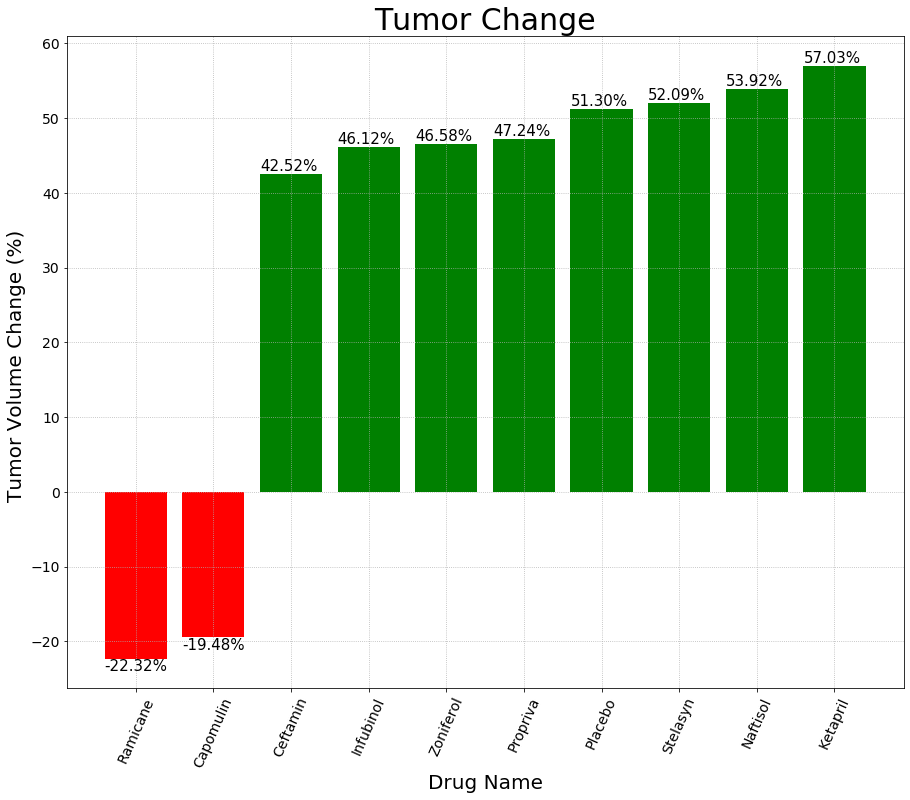

In [168]:
def autolabel(rects):
    for idx,rect in enumerate(rects):
        height = rect.get_height()
        plt.text(rect.get_x(), height,\
                sorted_df['Percent_Change'].iloc[idx + 2],\
                ha='left', va='bottom', rotation=0, color='k', fontsize=15)
def autolabel_neg(rects):
    for idx,rect in enumerate(rects):
        height = rect.get_height()
        plt.text(rect.get_x(), height - 2,\
                sorted_df['Percent_Change'].iloc[idx],\
                ha='left', va='bottom', rotation=0, color='k', fontsize=15)

plt.figure(figsize=(15,12))
plt.title('Tumor Change', fontsize=30)

plt.xlabel('Drug Name', fontsize=20)
plt.ylabel('Tumor Volume Change (%) ', fontsize=20)

# Splice the data between passing and failing drugs
neg_drugs = change_df[change_df['Percent'] < 0].sort_values('Percent')
pos_drugs = change_df[change_df['Percent'] >= 0].sort_values('Percent')

plt.grid(linestyle='dotted')
bar_plot = plt.bar(neg_drugs.index.values, neg_drugs['Percent'], color='r', label = neg_drugs.index.values)
bar_plot2 = plt.bar(pos_drugs.index.values, pos_drugs['Percent'], color='g', label = pos_drugs.index.values)

autolabel_neg(bar_plot)
autolabel(bar_plot2)

plt.xticks(rotation = 66, fontsize=14)
plt.yticks(fontsize=14)

    
plt.savefig('Tumor_change_Per.png')

plt.show()
